# Analyze best neighbor search with early stop and dynamic distance threshold

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from optimization.analyze_codes.decoder_performance_from_state import evaluate_performance_of_state
from optimization.experiments_settings import generate_neighbor_highlight, from_edgelist, load_tanner_graph, parse_edgelist
from optimization.experiments_settings import codes, path_to_initial_codes, textfiles

codes = ['[625,25]', '[1225,65]', '[1600,64]', '[2025,81]']
fn_data = {}

import h5py
import numpy as np

code: [1225,65]
Total runtime for [[1225,65]]: 3.0h 50.0m 38.41727805137634s
Physical error rate p: 0.03, MC budget: 1e+05
Number of steps L: 10, neighbors per step (incl. initial) N: 50
OSD order: 2, MS scaling factor: 0.625
logical error rate of initial state: 0.02266 ± 0.0004706032922479259
Best logical error rate found at step 366:
Best logical error rate found: 0.00235 ± 0.00015311763272103735
Initial state classical code parameters: [28, 8, 6]
Best state classical code parameters found: [28, 7, 10]
Number of valid neighbors per step (excluding initial): [3, 10, 10, 7, 4, 8, 6, 8, 7, 4]
----------------------------------------------------------------------------------------------------


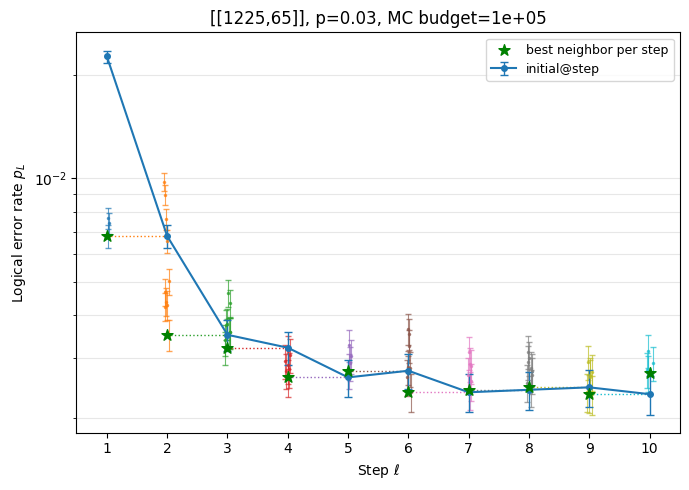

code: [1600,64]
Total runtime for [[1600,64]]: 0.0h 0.0m 0.0s
Physical error rate p: 0.03, MC budget: 1e+05
Number of steps L: 10, neighbors per step (incl. initial) N: 50
OSD order: 2, MS scaling factor: 0.625
logical error rate of initial state: 0.01298 ± 0.00035793362117126075
Best logical error rate found at step 125:
Best logical error rate found: 0.00191 ± 0.0001380713932612269
Initial state classical code parameters: [32, 8, 6]
Best state classical code parameters found: [32, 8, 10]
Number of valid neighbors per step (excluding initial): [10, 10, 10, 9]
----------------------------------------------------------------------------------------------------


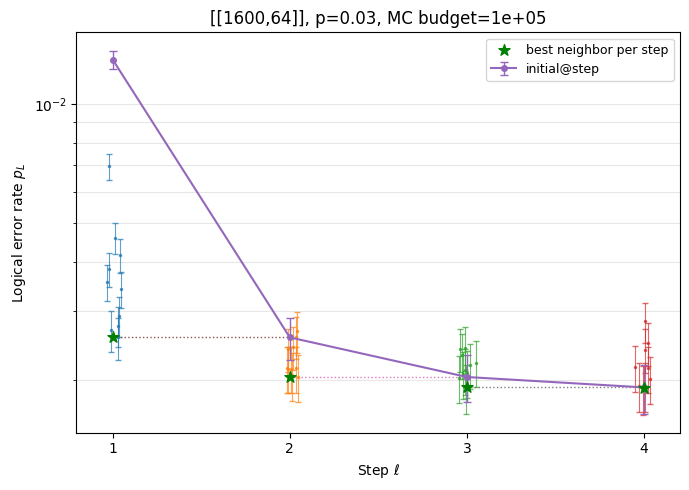

code: [625,25]
Total runtime for [[625,25]]: 1.0h 50.0m 12.369638919830322s
Physical error rate p: 0.03, MC budget: 1e+05
Number of steps L: 10, neighbors per step (incl. initial) N: 50
OSD order: 2, MS scaling factor: 0.625
logical error rate of initial state: 0.01254 ± 0.00035189305518470076
Best logical error rate found at step 234:
Best logical error rate found: 0.00332 ± 0.00018190686325993585
Initial state classical code parameters: [20, 5, 6]
Best state classical code parameters found: [20, 5, 8]
Number of valid neighbors per step (excluding initial): [6, 10, 8, 10, 10, 10, 10, 5, 10, 7]
----------------------------------------------------------------------------------------------------


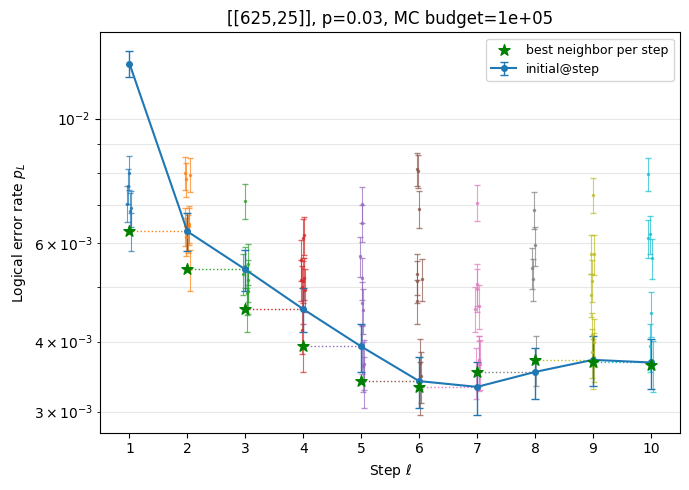

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import h5py

best_neighbor_search_path = './optimization/results/best_neighbor_search_early_stop_copy.hdf5'

with h5py.File(best_neighbor_search_path, 'r') as f:
    for code, grp in f.items():
        print(f"code: {code}")
        # Streams (1D each, same length)
        y  = grp['logical_error_rates'][()]          # shape (T,)
        ye = grp['logical_error_rates_std'][()]      # shape (T,)
        distances_classical = grp['distances_classical'][()]  # shape (T,)
        k_classical = grp['k_classical'][()]            # shape (T,)
        n_classical = grp['n_classical'][()]            # shape (T,)

        step_summ = grp['step_summaries'][()]        # shape (S, 4) -> [start, scanned, valid, chosen_row]
        S = step_summ.shape[0]

        y_pos = np.where(y > 0, y, np.inf)

        print(f"Total runtime for [{code}]: {grp.attrs['total_runtime'] // 3600}h {grp.attrs['total_runtime'] % 3600 // 60}m {grp.attrs['total_runtime'] % 60}s")
        print(f"Physical error rate p: {grp.attrs['p']}, MC budget: {grp.attrs['MC_budget']:.0e}")
        print(f"Number of steps L: {grp.attrs['L']}, neighbors per step (incl. initial) N: {grp.attrs['N']}")
        print(f"OSD order: {grp.attrs['osd_order']}, MS scaling factor: {grp.attrs['ms_scaling_factor']}")
        
        print(f"logical error rate of initial state: {y[0]} ± {ye[0]}")
        print(f"Best logical error rate found at step {np.argmin(y_pos)}:")
        print(f"Best logical error rate found: {np.min(y_pos)} ± {ye[np.argmin(y_pos)]}")
        print(f"Initial state classical code parameters: [{n_classical[0]}, {k_classical[0]}, {int(distances_classical[0])}]")
        print(f"Best state classical code parameters found: [{n_classical[np.argmin(y_pos)]}, {k_classical[np.argmin(y_pos)]}, {int(distances_classical[np.argmin(y_pos)])}]")

        print(f"Number of valid neighbors per step (excluding initial): {[int(step_summ[s,2]) for s in range(S)]}")
        print("-"*100)

        # Recover the series of "initial states" per step:
        # - The very first initial state is the *first* row in the file (index 0), appended before any scan.
        # - Each subsequent step's initial is the chosen_row_index from the previous step.
        initial_indices = [0]
        for s in range(S-1):
            chosen = int(step_summ[s, 3])
            if chosen >= 0:
                initial_indices.append(chosen)
            else:
                # fallback: if missing, repeat previous initial
                initial_indices.append(initial_indices[-1])

        # Prepare figure
        fig, ax = plt.subplots(figsize=(7, 5))
        x_steps = np.arange(1, S+1)

        # Plot neighbor clouds per step (exclude the initial of the step;
        # a step's neighbor rows are [start, start+scanned).)
        rng = np.random.default_rng(0)
        for s in range(S):
            start, scanned, valid, chosen = step_summ[s].astype(int)
            if scanned <= 0:  # nothing was scanned
                continue
            # All scanned neighbors are exactly the rows start .. start+scanned-1
            rows = np.arange(start, start + scanned, dtype=int)

            # Draw jittered points (LER) for the step
            jitter = rng.uniform(-0.05, 0.05, size=len(rows))
            ax.errorbar(
                x_steps[s] + jitter, y[rows], yerr=1.96*ye[rows],
                fmt='.', markersize=3, elinewidth=0.8, capsize=2, alpha=0.7, label=None
            )

        # Initial state trace (one per step)
        ax.errorbar(
            x_steps, y[initial_indices], yerr=1.96*ye[initial_indices],
            fmt='o-', markersize=4, elinewidth=1, capsize=3, label='initial@step'
        )

        # Best neighbor per step (among scanned rows only)
        best_cost_per_step = []
        for s in range(S):
            start, scanned, valid, chosen = step_summ[s].astype(int)
            if scanned > 0:
                rows = np.arange(start, start + scanned, dtype=int)
                # exclude non-positive LERs if any
                vals = np.where(y[rows] > 0, y[rows], np.inf)
                best_cost = np.min(vals) if np.any(np.isfinite(vals)) else np.nan
            else:
                best_cost = np.nan
            best_cost_per_step.append(best_cost)

        ax.scatter(x_steps, best_cost_per_step, marker='*', s=70, c='g', label='best neighbor per step', zorder=3)

        # Optionally connect best@step to initial@(next step)
        for s in range(S-1):
            if np.isfinite(best_cost_per_step[s]):
                ax.plot(
                    [x_steps[s], x_steps[s+1]],
                    [best_cost_per_step[s], y[initial_indices[s+1]]],
                    linestyle=':', linewidth=1, alpha=1
                )

        # Decorations
        title = f"[{code}], p={grp.attrs['p']}, MC budget={grp.attrs['MC_budget']:.0e}"
        ax.set_title(title)
        ax.set_xlabel('Step $\\ell$')
        ax.set_ylabel('Logical error rate $p_L$')
        ax.set_yscale('log')
        ax.grid(True, which='both', axis='y', alpha=0.3)
        if S <= 15:
            ax.set_xticks(x_steps)
        else:
            ax.set_xticks(np.linspace(1, S, min(10, S), dtype=int))
        ax.legend(loc='best', fontsize=9)
        plt.tight_layout()
        plt.show()


## Analysis of the best code from best_neighbor_search_early_stop 

In [10]:
from optimization.analyze_codes.decoder_performance_from_state import evaluate_performance_of_state

codes = ['[625,25]']
C = 0  # index into codes list
with h5py.File(best_neighbor_search_path, 'r') as f:
    min_cost = min(v for v in f[codes[C]]['logical_error_rates'] if v > 0)
    index_of_min = np.argmin(f[codes[C]]['logical_error_rates'])
    best_state_edge_list = f[codes[C]]['best_state'][()]
    print(f"Minimum logical error rate found in state {index_of_min} with value {min_cost}")
    print(f"best state edge list: {best_state_edge_list}")
    best_state = from_edgelist(best_state_edge_list)

MC_budget = int(1e6)
p = 0.03
best_code_result = evaluate_performance_of_state(state=best_state, p_vals=[p], MC_budget=MC_budget, distance_threshold=8, canskip=False)

Minimum logical error rate found in state 1 with value 0.00332
best state edge list: [[ 0 20  0 20  0 24  0 30  1 15  1 21  1 25  1 31  2 15  2 22  2 26  2 28
   2 34  3 15  3 16  3 26  3 31  4 16  4 22  4 25  4 30  5 16  5 23  5 28
   5 32  6 17  6 20  6 27  6 33  7 17  7 22  7 27  7 31  8 17  8 21  8 23
   8 30  9 21  9 28  9 32  9 33 10 18 10 18 10 23 10 26 11 18 11 24 11 29
  11 34 12 19 12 27 12 29 12 34 13 19 13 24 13 32 13 33 14 19 14 25 14 29]]
H: [20, 5, 8]
H^T: [15, 0, inf]
Q: [[625, 25, 8]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ldpc/code_util/code_util.py:164: UserWarning: This function has exponential complexity. Not recommended for large pcms. Use the                            'ldpc.code_util.estimate_code_distance' function instead.
  warnings.warn(


Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Best neighbor search finished in 12.0m 49.69s with 3751 failures out of 1000000 runs.
Logical error rate for Best neighbor search: 0.003751 ± 0.0000611 (stderr)
